In [1]:
from skimage.measure import profile_line
from skimage.measure import points_in_poly
from skimage.measure import find_contours
from skimage.filters import threshold_otsu
from scipy import stats
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
###
mat = scipy.io.loadmat('PENTIRE.mat')
P = mat['P'].reshape((60736,3)).astype(float)

In [3]:
mat = scipy.io.loadmat('MapShorelinePython.mat')

In [4]:
transectsX = mat['transectsX']
transectsY = mat['transectsY']
Iplan = mat['Iplan']

Collect the RGB values of the pixels along the transects.

In [5]:
#TESTINNG THE TIME
start = time.time()
P = np.empty((0,3))

for i in np.arange(1,transectsX.shape[1]+1,1):
        M1 = transectsY[0,i-1]
        M1 = (M1*2)
        M2 = transectsY[1,i-1]
        M2 = (M2*2)
        N1 = transectsX[0,i-1]
        N1 = ((N1 + 400) * 2)
        N2 = transectsX[1,i-1]
        N2 = ((N2 + 400) * 2)
        prof = profile_line(Iplan, (M1, N1), (M2, N2))
        P = np.append(P, prof, axis = 0)
        if i == transectsX.shape[1]:
            break
        else:
            M1 = transectsY[1,i-1]
            M1 = (M1*2)-1
            M2 = transectsY[0,i]
            M2 = (M2*2)-1
            N1 = transectsX[1,i-1]
            N1 = ((N1 + 400) * 2)
            N2 = transectsX[0,i]
            N2 = ((N2 + 400) * 2)
            prof = profile_line(Iplan, (M1, N1), (M2, N2))
            P = np.append(P, prof, axis = 0)
    
end = time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 3.5055768489837646


Create an array of red minus blue values (RmB) for the sampled pixels. From these produce a probabily density estimate.

In [13]:
RmBsample = P[: , 0] - P[: , 2]
kde = stats.gaussian_kde(RmBsample)
pdf_locs = np.linspace(RmBsample.min(), RmBsample.max(), 400, endpoint=True)

pdf_values = kde(pdf_locs)

The plot below is simply to visualise the density estimate

In [7]:
%matplotlib qt
plt.plot(pdf_locs, pdf_values)
plt.show()
plt.xlabel("RmB, aka 'pdf_locs'")
plt.ylabel("Probability, aka 'pdf_values'")
plt.title("Probability distribution (Python)")

Text(0.5, 1.0, 'Probability distribution (Python)')

Find the locations of the density peaks (the negative peak, J1, for wet pixels, the positive, J2, for dry

In [14]:
thresh_otsu = threshold_otsu(RmBsample)
thresh_weightings = [1/3, 2/3]
I1 = np.argwhere(pdf_locs < thresh_otsu)
J1 = np.argmax(pdf_values[I1])
I2 = np.argwhere(pdf_locs > thresh_otsu)
J2 = np.argmax(pdf_values[I2])

RmBwet = pdf_locs[I1[J1,0]]
RmBdry = pdf_locs[I2[J2,0]]

thresh = thresh_weightings[0]*RmBwet + thresh_weightings[1]*RmBdry

thresh

35.48788638262322

Representing everything so far on one plot:

In [7]:
A = [pdf_locs[I1[J1,0]], pdf_locs[I2[J2,0]]]
B = [pdf_values[I1[J1,0]], pdf_values[I2[J2,0]]]

In [8]:
%matplotlib qt
fig, axes = plt.subplots()
axes.plot(pdf_locs, pdf_values)
axes.scatter(A,B, color = 'r', marker = 'o',label='RmBwet(left) RmBdry(right)')
YL = axes.get_ylim()
axes.plot([thresh, thresh], YL, color = 'r', linestyle = ':',label='thresh')
axes.plot([thresh_otsu, thresh_otsu], YL, color = 'g', linestyle = ':', label='thresh otsu')
plt.xlabel("Red minus blue")
plt.ylabel("Probability")
plt.title("Variables represented on the probability distribution (Python)")
axes.legend()

#### Key:

 | Variable: | Represented by: |
 | --- | --- |
 | Otsu threshold | Red dotted line |
 | RmB<sub>wet</sub> | Red circle on left |
 | RmB<sub>dry</sub> | Red circle on right |
 | RmB<sub>opt</sub> | Green dotted line |

Text(0.5, 1.0, 'Plan Red minus Blue Image (Python)')

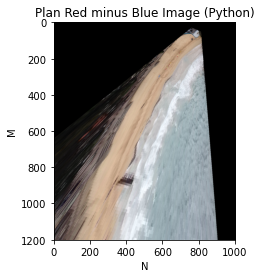

In [6]:
plt.imshow(Iplan.astype(int))
plt.xlabel("N")
plt.ylabel("M")
plt.title("Plan Red minus Blue Image (Python)")

Iplan must be converted to the float format in order for the red minus blue calculation to operate as desired.
The float format is also required for converting an array element to a NaN (in the cell which uses np.nan later on).

In [7]:
Iplan = Iplan.astype("float")
RminusBdouble = Iplan[:,:,0] - Iplan[:,:,2]

Text(0.5, 1.0, 'Plan Red minus Blue Image (Python)')

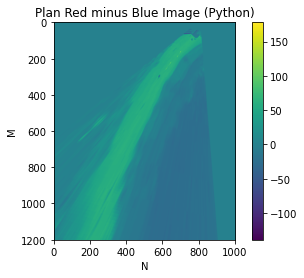

In [8]:
plt.imshow(RminusBdouble)
plt.colorbar()
plt.xlabel("N")
plt.ylabel("M")
plt.title("Plan Red minus Blue Image (Python)")

Text(0.5, 1.0, 'Region of interest (Python)')

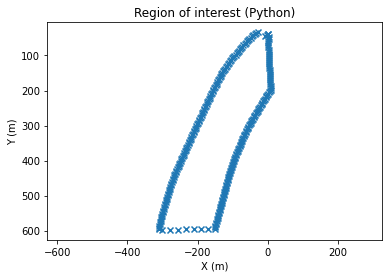

In [10]:
ROIx = np.concatenate((transectsX[0,:], np.flipud(transectsX[1,:])))
ROIy = np.concatenate((transectsY[0,:], np.flipud(transectsY[1,:])))
plt.scatter(ROIx,ROIy,marker='x')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Region of interest (Python)")

In [16]:
X = mat['X']
Y = mat['Y']
XFlat = X.flatten()
YFlat = Y.flatten()
points = np.column_stack((XFlat, YFlat))
verts = np.column_stack((ROIx, ROIy))

In [17]:
Imask = ~points_in_poly(points, verts)
Imask = np.reshape(Imask,[X.shape[0],X.shape[1]])

In [18]:
RminusBdouble[Imask] = np.nan

In [19]:
%matplotlib qt
plt.imshow(RminusBdouble)
plt.show()
plt.xlabel("M")
plt.ylabel("N")
plt.title("RminusBdouble in ROI (Python)")

Text(0.5, 1.0, 'RminusBdouble in ROI (Python)')

In [23]:
#defining thresh the same as that in MATLAB for testing
thresh = 34.36453958631399

In [24]:
c = find_contours(RminusBdouble,thresh)

Find the number of vertices in each of the contours representing the threshold level and add this information to the variable c_lengths.
Afterwards plot all of the contours representing the threshold level.

In [27]:
c_lengths = np.empty(0)
for i in range(len(c)):
    c_lengths = np.append(c_lengths, len(c[i]))

    plt.plot(c[i][:,1],c[i][:,0],'r-')

plt.imshow(RminusBdouble)
plt.show()
plt.xlabel("M")
plt.ylabel("N")
plt.title("Contours on RminusBdouble (Python)")

Text(0.5, 1.0, 'Contours on RminusBdouble (Python)')

Identify the location of the longest contour and thereafter plot it.

In [28]:
longest_contour_loc = np.argmax(c_lengths)

Shoreline contour points (note: these coordinates are not the same calibration as those in MATLAB):

In [29]:
xyz_x = c[longest_contour_loc][:,1]
xyz_y = c[longest_contour_loc][:,0]

Plot:

In [32]:
plt.plot(xyz_x,xyz_y, color = 'r')
plt.imshow(Iplan.astype("int"))
plt.show()
plt.xlabel("M")
plt.ylabel("N")
plt.title("Shoreline (Python)")

Text(0.5, 1.0, 'Shoreline (Python)')

In [35]:
A = np.column_stack((xyz_x.T, xyz_y.T))
A

array([[ 803.        ,  119.54515347],
       [ 802.31773021,  120.        ],
       [ 802.        ,  120.31773021],
       ...,
       [ 314.        , 1191.81773021],
       [ 313.9088651 , 1192.        ],
       [ 313.81773021, 1193.        ]])

In [38]:
(A/2)-400

array([[   1.5       , -340.22742326],
       [   1.1588651 , -340.        ],
       [   1.        , -339.8411349 ],
       ...,
       [-243.        ,  195.9088651 ],
       [-243.04556745,  196.        ],
       [-243.0911349 ,  196.5       ]])

In [39]:
A/2

array([[401.5       ,  59.77257674],
       [401.1588651 ,  60.        ],
       [401.        ,  60.1588651 ],
       ...,
       [157.        , 595.9088651 ],
       [156.95443255, 596.        ],
       [156.9088651 , 596.5       ]])